In [35]:
import matplotlib.pyplot as plt

%matplotlib inline

from collections import Counter
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import numpy as np
import pandas as pd
from scipy.sparse import dok_matrix
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score
from typing import List
from wordcloud import WordCloud

spam_dataset = pd.read_csv(
    'spam.csv',
    encoding='ISO-8859-1',
    usecols=[
        0,
        1,
    ],
    names=[
        'spam',
        'message',
    ],
    header=0)

spam_dataset['spam'] = np.where(spam_dataset['spam'].str.contains('spam'), 1, 0)

original_spam_ratio = len(spam_dataset[spam_dataset['spam'] == 1])/len(spam_dataset['spam'])
print(original_spam_ratio)

0.13406317300789664


In [36]:
X = spam_dataset['message']
y = spam_dataset['spam']

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y)

train_spam_ratio = len(y_train[y_train == 1])/len(y_train)
print(train_spam_ratio)

0.13417096701817366


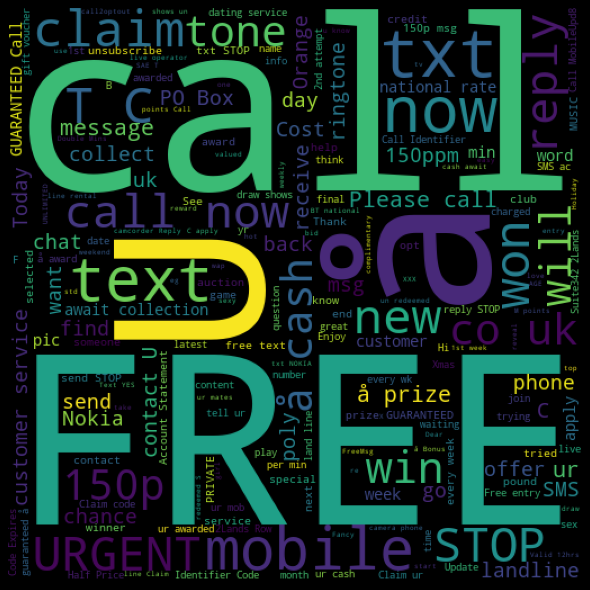

In [37]:
spam_words = ' '.join(list(X_train[y_train == 1]))
spam_wc = WordCloud(width=512, height=512).generate(spam_words)
plt.figure(figsize=(10, 8), facecolor='k')
plt.imshow(spam_wc)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

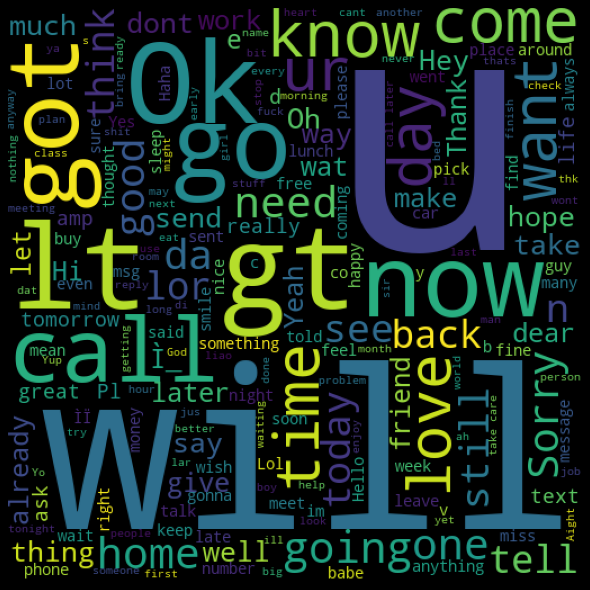

In [38]:
ham_words = ' '.join(list(X_train[y_train == 0]))
ham_wc = WordCloud(width=512, height=512).generate(ham_words)
plt.figure(figsize=(10, 8), facecolor='k')
plt.imshow(ham_wc)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

In [39]:
tokenizer = RegexpTokenizer(r'\w+')
stemmer = PorterStemmer()

def process_message(message: str, lower_case: bool=True, stem: bool=True, exclude_stopwords: bool=True) -> List[str]:
    if lower_case:
        message = message.lower()
    
    words = tokenizer.tokenize(message)

    if exclude_stopwords:
        exclude_words = stopwords.words('english')
        words = [word for word in words if word not in exclude_words]
    
    if stem:
        words = [stemmer.stem(word) for word in words]
    
    bag = Counter()
    
    for word in words:
        if word not in bag:
            bag[word] = 1
        else:
            bag[word] += 1

    return bag

print([(process_message(X_train.iloc[i]), y_train.iloc[i]) for i in range(0, 10)])

[(Counter({'go': 1, 'noth': 1, 'great': 1, 'bye': 1}), 0), (Counter({'wont': 1, 'wat': 1, 'wit': 1, 'guy': 1}), 0), (Counter({'ok': 1, 'k': 1, 'sri': 1, 'knw': 1, '2': 1, 'siva': 1, 'tat': 1, 'askd': 1}), 0), (Counter({'stand': 1, 'away': 1, 'heart': 1, 'ach': 1, 'without': 1, 'wonder': 1, 'crave': 1}), 0), (Counter({'finish': 1, 'work': 1, 'yet': 1, 'someth': 1}), 0), (Counter({'hhahhaahahah': 1, 'rofl': 1, 'wtf': 1, 'nig': 1, 'leonardo': 1, 'room': 1, 'someth': 1}), 0), (Counter({'wot': 1, 'u': 1, '2': 1, 'j': 1}), 0), (Counter({'hiya': 1, 'sorri': 1, 'hav': 1, 'signal': 1, 'seen': 1, 'heard': 1, 'neither': 1, 'unusu': 1, 'put': 1, 'case': 1, 'get': 1, 'sort': 1, 'hug': 1, 'snog': 1}), 0), (Counter({'r': 1, 'outsid': 1, 'alreadi': 1}), 0), (Counter({'free': 3, 'call': 2, 'nokia': 1, 'motorola': 1, 'upto': 1, '12mth': 1, '1': 1, '2price': 1, 'linerent': 1, '500': 1, 'x': 1, 'net': 1, 'min': 1, '100txt': 1, 'mth': 1, 'b': 1, 'tooth': 1, 'mobileupd8': 1, '08001950382': 1, '2optout': 1, 

In [40]:
class FeatureModel(object):
    def __init__(self, X, y, num_ham_words: int=100, num_spam_words: int=100):
        self.X = X
        self.y = y
        self.messages = []
        self.spam_words = Counter()
        self.ham_words = Counter()
        self.all_words = Counter()
        
        for index, row in X.iteritems():
            message = Counter()
            
            for word in process_message(row):

                if word not in self.all_words:
                    self.all_words[word] = 1
                else:
                    self.all_words[word] += 1
                
                if y[index] == 0:
                    if word not in self.ham_words:
                        self.ham_words[word] = 1
                    else:
                        self.ham_words[word] += 1
                
                if y[index] == 1:
                    if word not in self.spam_words:
                        self.spam_words[word] = 1
                    else:
                        self.spam_words[word] += 1
                
                if word not in message:
                    message[word] = 1
                else:
                    message[word] += 1
            
            self.messages.append(message)
        
        ham_list = sorted(self.ham_words.items(), key=lambda x: x[1], reverse=True)
        spam_list = sorted(self.spam_words.items(), key=lambda x: x[1], reverse=True)

        word_set = set()
        
        for i in range(num_ham_words):
            word_set.add(ham_list[i][0])
        
        for i in range(num_spam_words):
            word_set.add(spam_list[i][0])
        
        self.word_list = list(word_set)
    
def get_features(X, feature_model: 'FeatureModel') -> dok_matrix:
    features = dok_matrix((len(X), len(feature_model.word_list)), dtype=np.float32)
    for i in range(len(X)):
        message = process_message(X.iloc[i])
        for j in range(len(feature_model.word_list)):
            if feature_model.word_list[j] not in message:
                features[i, j] = 0
            else:
                features[i, j] = message[feature_model.word_list[j]]
    return features.toarray()

In [41]:
feature_model = FeatureModel(X_train, y_train)

features_train = get_features(X_train, feature_model)

In [42]:
cnb = MultinomialNB(alpha=1.0)

cnb.fit(features_train, y_train)

MultinomialNB()

In [43]:
cnb.predict(features_train[1:20])

array([0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0])

In [44]:
features_test = get_features(X_test, feature_model)

y_pred = cnb.predict(features_test)
cnb.score(features_test, y_test)

0.9739910313901345

In [47]:
print('The accuracy score is {}.'.format(accuracy_score(y_test, y_pred)))
print('The precision score is {}.'.format(precision_score(y_test, y_pred)))
print('The recall score is {}.'.format(recall_score(y_test, y_pred)))
print('The f1 score is {}.'.format(f1_score(y_test, y_pred)))

print('The confusion matrix is:')
print(confusion_matrix(y_test, y_pred))

The accuracy score is 0.9739910313901345.
The precision score is 0.910958904109589.
The recall score is 0.8926174496644296.
The f1 score is 0.9016949152542374.
The confusion matrix is:
[[953  13]
 [ 16 133]]
